# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:**  Ishita Rathore
**`Roll Number`:**  U20230044
**`GitHub Branch`:** ishita_U20230044

# Imports and Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from rlcmab_sampler import sampler


# Load Datasets

In [3]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print(news_df.head())
print(train_users.head())


                                                link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog y

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [4]:
print("News duplicates:", news_df.duplicated().sum())
print("Train users duplicates:", train_users.duplicated().sum())
print("Test users duplicates:", test_users.duplicated().sum())
print("News nulls:", news_df.isnull().sum())
print("Train users nulls:", train_users.isnull().sum())
print("Test users nulls:", test_users.isnull().sum())

News duplicates: 13
Train users duplicates: 0
Test users duplicates: 0
News nulls: link                     0
headline                 6
category                 0
short_description    19712
authors              37418
date                     0
dtype: int64
Train users nulls: user_id                          0
age                            698
income                           0
clicks                           0
purchase_amount                  0
session_duration                 0
content_variety                  0
engagement_score                 0
num_transactions                 0
avg_monthly_spend                0
avg_cart_value                   0
browsing_depth                   0
revisit_rate                     0
scroll_activity                  0
time_on_site                     0
interaction_count                0
preferred_price_range            0
discount_usage_rate              0
wishlist_size                    0
product_views                    0
repeat_purchase_gap (da

In [5]:
from sklearn.impute import SimpleImputer


num_cols = train_users.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_users[num_cols] = imputer.fit_transform(train_users[num_cols])
train_users['subscriber'] = train_users['subscriber'].astype(int)
train_users = train_users.drop(columns=['browser_version', 'region_code', 'user_id'])

num_cols_test = test_users.select_dtypes(include=['int64', 'float64']).columns
imputer_test = SimpleImputer(missing_values=np.nan, strategy='median')
test_users[num_cols] = imputer.fit_transform(test_users[num_cols])
test_users['subscriber'] = test_users['subscriber'].astype(int)
test_users = test_users.drop(columns=['browser_version', 'region_code', 'user_id'])

allowed_categories = ["ENTERTAINMENT", "EDUCATION", "TECH", "CRIME"]
news_df = news_df[news_df["category"].isin(allowed_categories)]
print(news_df["category"].unique())


<StringArray>
['TECH', 'ENTERTAINMENT', 'EDUCATION', 'CRIME']
Length: 4, dtype: str


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# train test dfs
X_users = train_users.drop(columns=['label'])
y_users = train_users['label']

encoder = LabelEncoder()
y_users = encoder.fit_transform(y_users)

scaler = StandardScaler()
X_users = scaler.fit_transform(X_users)

print("x_users;", X_users[:5])
print("y_users;", y_users[:5])

# news df
news_df = news_df.dropna(subset=['category'])
categories = news_df["category"].unique()
arms = {cat: i for i, cat in enumerate(categories)}
print("Arms mapping:", arms)

x_users; [[-1.60854271e-02  2.20907469e-01 -1.59472128e-01 -4.25788002e-01
  -6.72161351e-01 -5.10517755e-01 -4.89355638e-01 -1.17893364e+00
  -4.15620459e-01 -2.78104076e-01 -5.13933330e-01 -6.82975577e-01
  -5.66027245e-01 -5.84266582e-01  4.10286736e-01 -6.18276832e-01
   3.37140316e-01 -1.30614404e-03 -5.62355332e-01  7.33123871e-01
   2.96085692e-01 -6.44160503e-01  8.55123589e-01 -1.77700391e+00
   1.28836329e+00  1.57255018e-01  8.96136086e-01 -8.92810306e-01
  -6.20517164e-01]
 [ 1.83156498e+00 -1.96686850e-01  1.43706822e-01  7.00719320e-02
  -4.57787134e-01  5.01071763e-01  4.08397947e-01 -3.97924273e-01
  -5.17823809e-01  8.91122791e-02 -4.35655464e-01  1.33702265e+00
  -4.79205482e-01 -8.11667697e-02 -7.57290770e-01  8.89815635e-02
   6.09543584e-01  3.71877866e-01  9.00141720e-01 -3.73661559e-01
  -3.01484821e-01  1.24272136e+00  1.30893858e+00  4.25341496e-01
  -2.31704290e-02 -4.21420301e-01 -1.56122896e+00 -1.10905913e+00
   1.61155897e+00]
 [-1.60854271e-02 -1.13634827

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_users, y_users, test_size=0.2, random_state=44)

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [9]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8025
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       158
           1       0.84      0.88      0.86       128
           2       0.72      0.73      0.72       114

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400

[[126   3  29]
 [ 12 112   4]
 [ 13  18  83]]
Accuracy: 0.8025
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       158
           1       0.84      0.88      0.86       128
           2       0.72      0.73      0.72       114

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400

[[126   3  29]
 [ 12 112   4]
 [ 13  18  83]]


# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


In [10]:
import numpy as np
from rlcmab_sampler import sampler

reward_sampler = sampler(44)
num_contexts = 3
num_categories = 4
num_rounds = 1000
epsilons = [0.01, 0.1, 0.3, 0.5] 

## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [11]:
def run_epsilon_greedy(epsilon):
    N = np.zeros((num_contexts, num_categories))
    Q = np.zeros((num_contexts, num_categories))

    cumulative_reward = 0
    rewards = []

    for t in range(num_rounds):
        # decide which user.
        context = np.random.randint(0, num_contexts)

        # decide which arm for the user selected above.
        if np.random.rand() < epsilon:
            category = np.random.randint(0, num_categories)  # explore.
        else:
            category = np.argmax(Q[context])  # exploit.

        # decide which out of the 0th to 11th arm.
        j = context * num_categories + category

        # get reward.
        reward = reward_sampler.sample(j)

        # update and repeat.
        N[context, category] += 1
        Q[context, category] += (reward - Q[context, category]) / N[context, category]

        cumulative_reward += reward
        rewards.append(cumulative_reward / (t + 1))

    return Q, cumulative_reward / num_rounds, rewards


# to run over different epsilons.
results = {}

for ep in epsilons:
    Q_values_epgreedy, avg_reward, reward_curve = run_epsilon_greedy(ep)
    results[ep] = {"Q": Q_values_epgreedy, "avg_reward": avg_reward, "curve": reward_curve}
    print(f"Epsilon: {ep}")
    print(f"Average Reward: {avg_reward:.4f}")
    print("Estimated Reward Table:")
    print(Q_values_epgreedy)
    print("-" * 40)
# print(results) # this is a dict of different epsilon values as the keys and the other parameters as their values each.

Epsilon: 0.01
Average Reward: 5.6919
Estimated Reward Table:
[[-4.24387955 -4.90798921  8.5148249   5.87512912]
 [-1.31812353 -3.92935487  4.46214803  0.        ]
 [ 4.41949154 -6.90608347 -0.10280761  0.        ]]
----------------------------------------
Epsilon: 0.1
Average Reward: 5.2664
Estimated Reward Table:
[[-4.73477958 -4.04321085  8.45772558  6.62815752]
 [ 1.1441714  -6.13206491  4.50731949  3.51350759]
 [ 4.35240158 -6.58194888  0.36998944 -8.54981664]]
----------------------------------------
Epsilon: 0.3
Average Reward: 4.0176
Estimated Reward Table:
[[-4.90782196 -4.87331894  8.37626658  6.77030827]
 [ 1.25036627 -6.26520682  4.44103079  3.23422477]
 [ 4.43275013 -6.06862485 -0.03516802 -9.1504561 ]]
----------------------------------------
Epsilon: 0.5
Average Reward: 2.8622
Estimated Reward Table:
[[-5.12854022 -4.35695862  8.35057995  6.80287564]
 [ 1.02215729 -6.28932148  4.47151212  3.62420452]
 [ 4.32225104 -5.6962055  -0.08299083 -9.09172453]]
--------------------

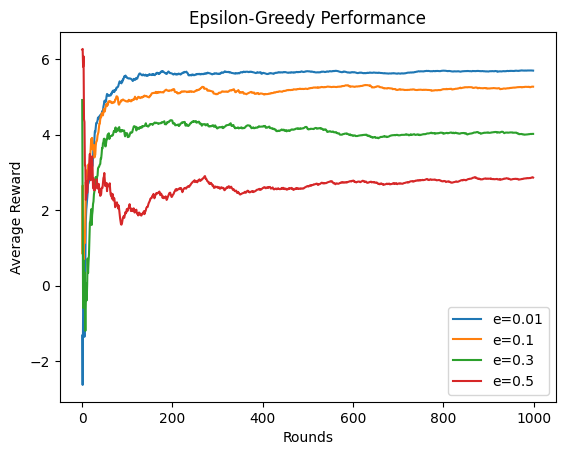

In [12]:
import matplotlib.pyplot as plt

for eps in epsilons:
    plt.plot(results[eps]["curve"], label=f"e={eps}")

plt.xlabel("Rounds")
plt.ylabel("Average Reward")
plt.legend()
plt.title("Epsilon-Greedy Performance")
plt.show()


In [13]:
best_epsilon = max(results, key=lambda e: results[e]["avg_reward"])

best_Q_eps = results[best_epsilon]["Q"]
best_avg_reward_eps = results[best_epsilon]["avg_reward"]

print("Best epsilon:", best_epsilon)
print("Best average reward:", best_avg_reward_eps)


Best epsilon: 0.01
Best average reward: 5.691869875838967


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [14]:
reward_sampler = sampler(44)
num_contexts = 3
num_categories = 4
num_rounds = 10000

C_values = [0.1, 0.5, 1, 2]  # exploration parameter

def run_ucb(C):

    N = np.zeros((num_contexts, num_categories))
    Q = np.zeros((num_contexts, num_categories))

    cumulative_reward = 0
    rewards = []

    for t in range(1, num_rounds + 1):

        context = np.random.randint(0, num_contexts)

        if 0 in N[context]:
            category = np.argmin(N[context])  # so the arm that is least explored is chosen.
        else:
            ucb_values = Q[context] + C * np.sqrt(np.log(t) / N[context])
            category = np.argmax(ucb_values)

        j = context * num_categories + category

        reward = reward_sampler.sample(j)

        # Update
        N[context, category] += 1
        Q[context, category] += (reward - Q[context, category]) / N[context, category]

        cumulative_reward += reward
        rewards.append(cumulative_reward / t)

    return Q, cumulative_reward / num_rounds, rewards

# now again for different epsilon values

results_ucb = {}

for C in C_values:
    Q_values_ucb, avg_reward, reward_curve = run_ucb(C)
    results_ucb[C] = {"Q": Q_values_ucb, "avg_reward": avg_reward, "curve": reward_curve}

    print(f"C: {C}")
    print(f"Average Reward: {avg_reward:.4f}")
    print("Estimated Reward Table:")
    print(Q_values_ucb)
    print("-" * 40)

C: 0.1
Average Reward: 5.7576
Estimated Reward Table:
[[-5.43047235 -2.7626805   8.44680981  6.78495597]
 [-0.13073639 -6.78428585  4.49247984  2.62953529]
 [ 4.34567958 -4.96840719  0.39828351 -8.90389569]]
----------------------------------------
C: 0.5
Average Reward: 5.7118
Estimated Reward Table:
[[-4.96436936 -4.20430577  8.41337275  6.63638125]
 [ 1.11308494 -3.3011551   4.51352252  2.50705545]
 [ 4.30910927 -4.9172934   0.33523994 -8.96926618]]
----------------------------------------
C: 1
Average Reward: 5.7453
Estimated Reward Table:
[[-6.07669818 -7.42330584  8.41215645  7.31538637]
 [ 0.95146148 -5.6488693   4.48809311  3.73540937]
 [ 4.35183782 -5.24855323  0.23737047 -8.90845213]]
----------------------------------------
C: 2
Average Reward: 5.7183
Estimated Reward Table:
[[-6.3070847  -3.58097886  8.38931302  6.6768419 ]
 [ 1.82062253 -7.76622099  4.48492003  3.39169426]
 [ 4.32135889 -5.0946671   0.28833222 -8.09161892]]
----------------------------------------


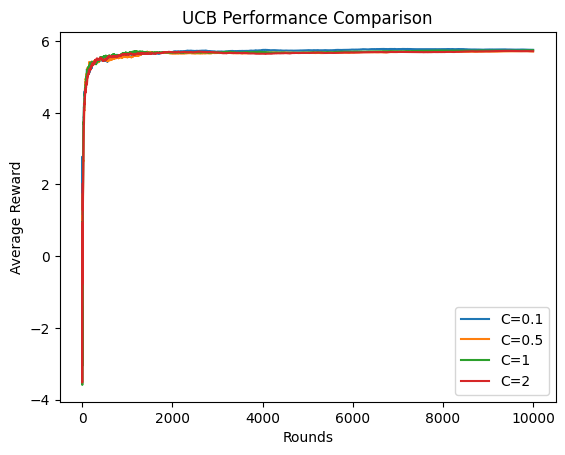

In [15]:
for C in C_values:
    plt.plot(results_ucb[C]["curve"], label=f"C={C}")

plt.xlabel("Rounds")
plt.ylabel("Average Reward")
plt.legend()
plt.title("UCB Performance Comparison")
plt.show()


In [17]:
best_C = max(results_ucb, key=lambda c: results_ucb[c]["avg_reward"])

best_Q_ucb = results_ucb[best_C]["Q"]
best_avg_reward_ucb = results_ucb[best_C]["avg_reward"]

print("Best C:", best_C)
print("Best average reward:", best_avg_reward_ucb)

Best C: 0.1
Best average reward: 5.757575084468527


## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [18]:
tau = 1.0

def run_softmax():

    N = np.zeros((num_contexts, num_categories))
    Q = np.zeros((num_contexts, num_categories))

    cumulative_reward = 0
    rewards = []

    for t in range(1, num_rounds + 1):

        context = np.random.randint(0, num_contexts)

        exp_values = np.exp(Q[context] / tau)
        probabilities = exp_values / np.sum(exp_values)

        category = np.random.choice(num_categories, p=probabilities)

        j = context * num_categories + category

        reward = reward_sampler.sample(j)

        N[context, category] += 1
        Q[context, category] += (reward - Q[context, category]) / N[context, category]

        cumulative_reward += reward
        rewards.append(cumulative_reward / t)

    return Q, cumulative_reward / num_rounds, rewards


In [19]:
Q_values_softmax, avg_reward_softmax, reward_curve_softmax = run_softmax()

print("Softmax (tau = 1)")
print(f"Average Reward: {avg_reward_softmax:.4f}")
print("Estimated Reward Table:")
print(Q_values_softmax)
print("-" * 40)

Softmax (tau = 1)
Average Reward: 5.6113
Estimated Reward Table:
[[  0.          -4.1558951    8.42082678   6.80860735]
 [  0.98180688  -5.97398813   4.4861644    3.61661084]
 [  4.31399656  -6.40944619   0.14112759 -10.01892175]]
----------------------------------------


In [21]:
best_Q_softmax = Q_values_softmax
best_avg_reward_softmax = avg_reward_softmax
print(best_avg_reward_softmax)

5.611311353506533


## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


In [26]:
categories = news_df["category"].unique()
arms = {i: cat for i, cat in enumerate(categories)}
print("Arms mapping:", arms)


def recommend_news(user_row, classifier, Q_values):

    user_features = user_row.values.reshape(1, -1)
    context = classifier.predict(user_features)[0]
    print("User:", context)

    arm_index = np.argmax(Q_values[context])
    category = arms[arm_index]

    category_articles = news_df[news_df["category"] == category]

    sampled_article = category_articles.sample(1).iloc[0]

    return {
        "predicted_context": context,
        "recommended_category": category,
        "article_title": sampled_article["headline"]
    }


Arms mapping: {0: 'TECH', 1: 'ENTERTAINMENT', 2: 'EDUCATION', 3: 'CRIME'}


In [28]:
# epsilon greedy
print("Epsilon Greedy Q values")
for idx, row in test_users.iterrows():

    recommendation_epgreedy = recommend_news(row, clf, best_Q_eps)

    print("Predicted Context:", recommendation_epgreedy["predicted_context"])
    print("Recommended Category:", recommendation_epgreedy["recommended_category"])
    print("Article Title:", recommendation_epgreedy["article_title"])
    print("-" * 50)

Epsilon Greedy Q values
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Special Education Case At Supreme Court Could Prove Costly For Schools
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Employers Take Note: People with Autism Ideally Suited to Fill Critical STEM Jobs
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: If Ever There Was a Kid Born to Read
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Making the Humanities Relevant
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Why We Should Care About Boys and Young Men of Color
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Articl

In [30]:

print("UCB Q values")
# ucb
for idx, row in test_users.iterrows():

    recommendation_ucb = recommend_news(row, clf, best_Q_ucb)

    print("Predicted Context:", recommendation_ucb["predicted_context"])
    print("Recommended Category:", recommendation_ucb["recommended_category"])
    print("Article Title:", recommendation_ucb["article_title"])
    print("-" * 50)

UCB Q values
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Public School Apartheid in Harlem
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Teacher Seniority: The Seat Belts Of The Education Profession
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: The Global Search for Education: Latin America is Online
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: "Is Autism a Disability or a Difference?"
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Voucher Champs Take Note: Illinois’ $75M Tax Credit Offset Funding Does Not Exist
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title:

In [31]:
print("Softmax Q values")
# softmax
for idx, row in test_users.iterrows():

    recommendation_softmax = recommend_news(row, clf, best_Q_softmax)

    print("Predicted Context:", recommendation_softmax["predicted_context"])
    print("Recommended Category:", recommendation_softmax["recommended_category"])
    print("Article Title:", recommendation_softmax["article_title"])
    print("-" * 50)


Softmax Q values
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Opposition Rallies Against Plan To Put Unqualified People In Classrooms
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Homage to My Teachers
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: The Global Search for Education: Creative China
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Health Education Takes Center Stage
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Do Millennials Have Good Money Habits?
--------------------------------------------------
User: 0
Predicted Context: 0
Recommended Category: EDUCATION
Article Title: Podcast: Students Say 'We Don't Want to Become Robots'


## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


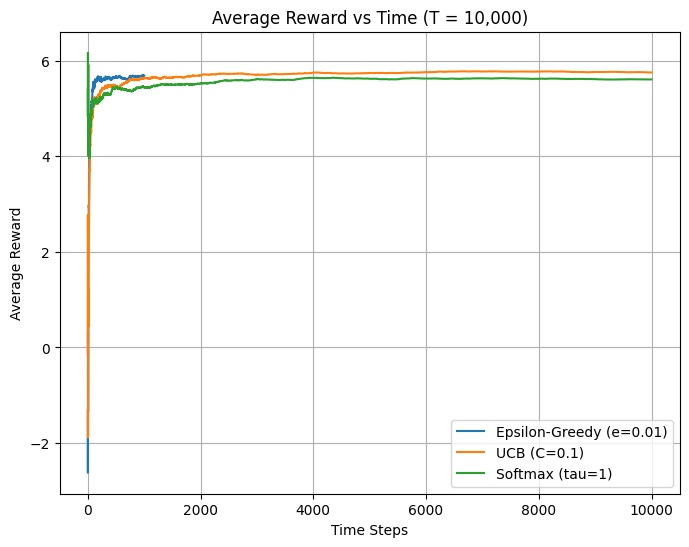

In [34]:
plt.figure(figsize=(8,6))

plt.plot(results[best_epsilon]["curve"], label=f"Epsilon-Greedy (e={best_epsilon})")
plt.plot(results_ucb[best_C]["curve"], label=f"UCB (C={best_C})")
plt.plot(reward_curve_softmax, label="Softmax (tau=1)")

plt.xlabel("Time Steps")
plt.ylabel("Average Reward")
plt.title("Average Reward vs Time (T = 10,000)")
plt.legend()
plt.grid(True)
plt.show()

# --------------------------------------------------------x-----------------------------------------------------------


## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach
